# Improving the benchmark machine learning analysis for predicting earthquake damage

This notebook builds on the benchmark analysis to improve the predictions of earthquake damage. Including, adding more features, adding other algorithms, tuning the hyperparameters and stratifying the cross-validation to deal with data imbalance.

In [11]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Define data paths and load data.

In [12]:
DATA_DIR = Path('data', 'raw')
SUB_DIR = Path('submissions')

train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

## Classification model

Load functionality:

In [13]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# the model
from sklearn.linear_model import LogisticRegression

# for processing the data
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# for displaying the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

Start by adding more features (numerical and categorical):

In [14]:
num_features = ['geo_level_1_id',
                'geo_level_2_id',
                'geo_level_3_id',
                'age',
                'area_percentage', 
                'height_percentage',
                'count_floors_pre_eq',
                'count_families']

cat_features = ['land_surface_condition',
                'foundation_type',
                'ground_floor_type']

features = num_features + cat_features

train_values_subset = train_values[features]

# create labels variable
labels = train_labels.damage_grade.to_numpy()

Create processing pipeline (scaling the numerical features and one-hot encoding the categorical ones):

In [15]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)])


pipe = Pipeline([("preprocessing", preprocessor),
                ("classifier", LogisticRegression(random_state=0, verbose=False))])

Save some data for validation:

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_values_subset, labels, 
                                                  random_state=42, stratify=labels, test_size=0.2)

Train the model on the training data and tune hyperparameters using a stratified grid-seach cross-validation approach:

In [17]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200]
}

stratified_kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy')
grid_search.fit(X_train, y_train)


c:\Users\md82\AppData\Local\anaconda3\envs\ai-env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\md82\AppData\Local\anaconda3\envs\ai-env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\md82\AppData\Local\anaconda3\envs\ai-env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\md82\AppData\Local\anaconda3\envs\ai-env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\md82\AppData\Local\anaconda3\envs\ai-env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['geo_level_1_id',
                                                                          'geo_level_2_id',
                                                                          'geo_level_3_id',
                                                                          'age',
                                                                          'area_percentage',
                                                                          'height_percentage',
                                                                          'count_floors_pre_eq',
                                                                          'count_families']),
                                                                        ('cat',
                                                                         Pi...der',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['land_surface_condition',
                                                                          'foundation_type',
                                                                          'ground_floor_type'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=0,
                                                           verbose=False))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__max_iter': [100, 200],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='accuracy')

Show training results:

In [18]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score:  0.5730861473522639


Display confusion matrix and f1-score using the validation data:

0.5723988411580745

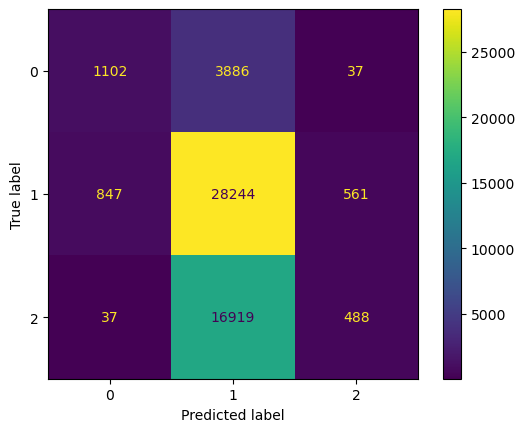

In [20]:
out_sample_preds = grid_search.predict(X_val)

cm = confusion_matrix(y_val, out_sample_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

f1_score(y_val, out_sample_preds, average='micro')

## Prepare and save submission

Some boilerplate code for running the model on the test dataset and saving the predictions for submission:

In [21]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

test_values_subset = test_values[features]
predictions = grid_search.predict(test_values_subset)

submission_format = pd.read_csv(SUB_DIR / 'submission_format.csv', index_col='building_id')

my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

my_submission.head()

my_submission.to_csv(SUB_DIR / 'submission.csv')